In [1]:
import os
import errno
import random
import skimage.io as io
import numpy as np
from tensorflow.python import keras
import matplotlib.pyplot as plt
from deepcell import model_zoo
import xarray as xr

/usr/local/lib/python3.5/dist-packages/deepcell/utils/__init__.py:49: UserWarning: To use `compute_overlap`, the C extensions must be built using `python setup.py build_ext --inplace`
  warnings.warn('To use `compute_overlap`, the C extensions must be built '


In [20]:
CHANNEL_AXIS = 3
training_data = np.load(os.path.join('/data/npz_data', 
                                     "Training_Freeze_1_Nuc_Val" + ".npz"))

X, y = training_data["X"], training_data["y"]
print("X.shape: {} & y.shape: {}".format(X.shape, y.shape))

X.shape: (5, 1024, 1024, 5) & y.shape: (5, 1024, 1024, 1)


In [13]:
X = X[:, :, :, 1:2]

In [4]:
# trained model setings
receptive_field = 81  # should be adjusted for the scale of the data
win = (receptive_field - 1) // 2  # sample window size
distance_bins = 4  # number of distance "classes"

In [4]:
hist = np.load('/data/models/20190914_tuning/Training_Freeze_1_Nuc_watershed_81_rf_256_dense_64_conv_2erosion.npz')
hist['loss_history'].tolist()['acc']

[0.6211040026246719,
 0.6423166830708661,
 0.649165436351706,
 0.6528170795056868,
 0.656289301727909,
 0.6601374535214348,
 0.6614925087489064,
 0.6645734224628171,
 0.6661096073928259,
 0.6672869504593176]

In [21]:
MODEL_NAME = 'Training_Freeze_1_Nuc_watershed_81_rf_256_dense_64_conv_2erosion' + "_epoch_03"
folder_name = '20190914_tuning'
watershed_weights_file = os.path.join('/data/models', folder_name, MODEL_NAME + ".h5")

In [22]:
# load watershed model
run_watershed_model = model_zoo.bn_feature_net_2D(
    dilated=True,
    receptive_field=receptive_field,
    n_features=distance_bins,
    input_shape=tuple(X.shape[1:]), 
    n_conv_filters=64,
    n_dense_filters=256)
run_watershed_model.load_weights(watershed_weights_file)

In [23]:
# run the model
test_images = run_watershed_model.predict(X[:1, ...])

In [26]:
xr_output = xr.DataArray(test_images, name=MODEL_NAME,
                         coords=[['point8'], range(1024), range(1024), ['level_0', 'level_1', 'level_2', 'level_3']],
                         dims=['points', 'rows', 'cols', 'masks'])
xr_output.to_netcdf(os.path.join('/data/models', "20190914_tuning", MODEL_NAME + "point1_output.nc"))

In [24]:
argmax_images = []
for j in range(test_images.shape[0]):
    argmax_images.append(np.argmax(test_images[j, ...], axis=-1))
argmax_images = np.array(argmax_images)

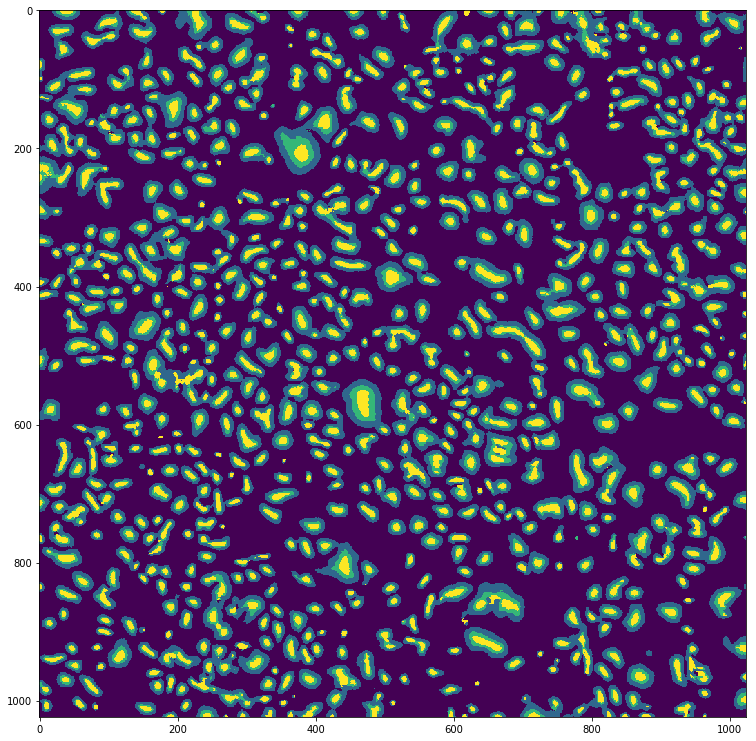

In [25]:
plt.figure(figsize = (13, 13))
plt.imshow(argmax_images[0, :, :])

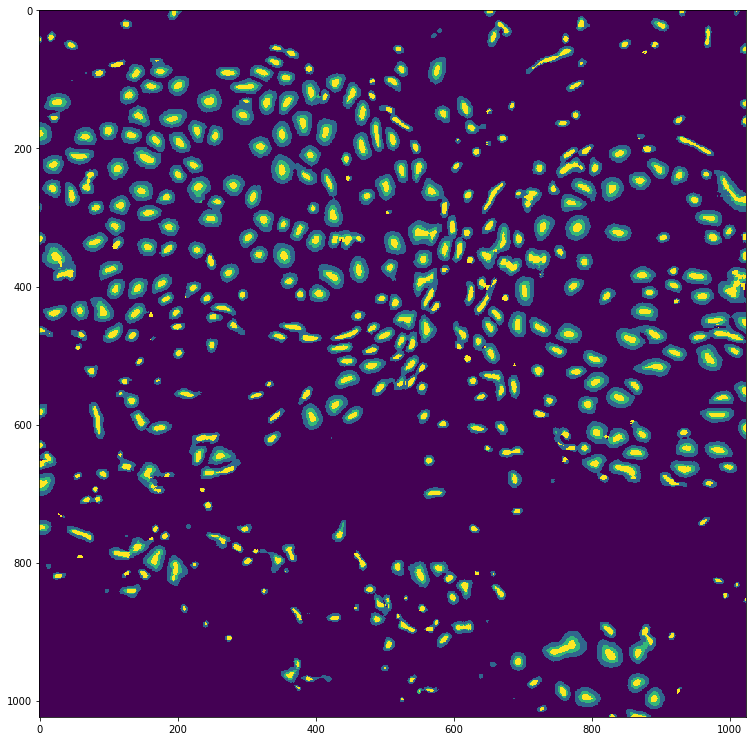

In [38]:
plt.figure(figsize = (13, 13))
plt.imshow(argmax_images[0, :, :])